In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pickle

In [2]:
def load_datasets():
    train = pd.read_table("../datasets/ritxt/train.txt", delimiter=";", header=None)
    val = pd.read_table("../datasets/ritxt/val.txt", delimiter=";", header=None)
    test = pd.read_table("../datasets/ritxt/test.txt", delimiter=";", header=None)
    generated = pd.read_table("../datasets/ritxt/generated.txt", delimiter=";", header=None)

    train.columns = ["Text", "Emotion"]
    val.columns = ["Text", "Emotion"]
    test.columns = ["Text", "Emotion"]
    generated.columns = ["Text", "Emotion"]

    data = pd.concat([train, val, test, generated], ignore_index=True)
    data.columns = ["text", "label"]
    emotion_counts = data['label'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette='viridis', legend=False)
    plt.title('Distribution of Emotions', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)
    plt.show()

    return train, val, test, data

In [3]:
def preprocess_text(text, lemmatizer=None):
    review = re.sub("[^a-zA-Z]", " ", text)
    review = review.lower()
    review = review.split()
    stop_words = set(stopwords.words("english"))

    if lemmatizer:
        review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    else:
        review = [PorterStemmer().stem(word) for word in review if word not in stop_words]

    return " ".join(review)

In [4]:
def filter_low_frequency_words(train, val, test, threshold=2):
    all_text = " ".join(train["text"].tolist() + val["text"].tolist() + test["text"].tolist())
    word_freq = Counter(all_text.split())

    for df in [train, val, test]:
        df["text"] = df["text"].apply(
            lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
        )
    return train, val, test

In [5]:
def prepare_data(train, val, test, tokenizer, max_len=100):
    tokenizer.fit_on_texts(train["text"])

    X_train = tokenizer.texts_to_sequences(train["text"])
    X_val = tokenizer.texts_to_sequences(val["text"])
    X_test = tokenizer.texts_to_sequences(test["text"])

    X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
    X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

    y_train = np.array(train["N_label"])
    y_val = np.array(val["N_label"])
    y_test = np.array(test["N_label"])

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def build_and_compile_model(vocab_size, embedding_dim, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


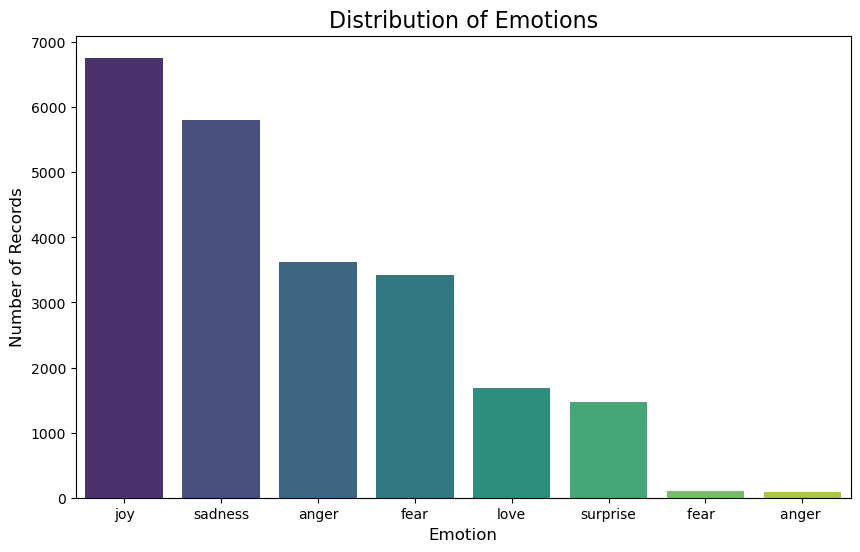

Epoch 1/10


c:\Users\10\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3935 - loss: 1.4395 - val_accuracy: 0.7120 - val_loss: 0.6459
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8007 - loss: 0.5280 - val_accuracy: 0.8800 - val_loss: 0.3488
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9132 - loss: 0.2659 - val_accuracy: 0.9070 - val_loss: 0.2944
Epoch 4/10
364/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9494 - loss: 0.1555

KeyboardInterrupt: 

In [8]:
def main():
    train, val, test, data = load_datasets()

    lemmatizer = WordNetLemmatizer()
    train["text"] = train["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    val["text"] = val["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    test["text"] = test["Text"].apply(lambda x: preprocess_text(x, lemmatizer))

    train, val, test = filter_low_frequency_words(train, val, test)

    label_encoder = preprocessing.LabelEncoder()
    train["N_label"] = label_encoder.fit_transform(train["Emotion"])
    val["N_label"] = label_encoder.transform(val["Emotion"])
    test["N_label"] = label_encoder.transform(test["Emotion"])

    max_len = 100
    tokenizer = Tokenizer(num_words=5000)
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(train, val, test, tokenizer, max_len)

    model = build_and_compile_model(vocab_size=5000, embedding_dim=128, max_len=max_len, num_classes=len(label_encoder.classes_))

    train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder)

    model.save("../exported_files/cnn.h5")
    with open("../exported_files/cnn_tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("../exported_files/cnn_label_encoder.pkl", "wb") as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


if __name__ == "__main__":
    main()
